In [1]:
# AAAI Submission 2017
# Detection baseline
# Make malignancy heatmap given an image

In [1]:
import numpy as np
import scipy
from scipy import misc
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from inception import inception_model

In [152]:
resize_factor = 1
imagename= "/media/esteva/ExtraDrive1/ThrunResearch/data/aaai2017/materials/"
# imagename = "/media/esteva/ExtraDrive1/ThrunResearch/data/edinburgh/test_sets/pigmented/7/ML/B69b/B69b.png"
# imagename = "/media/esteva/ExtraDrive1/ThrunResearch/data/edinburgh/test_sets/pigmented/8/MEL/B28/B28.png"
# imagename = "/media/esteva/ExtraDrive1/ThrunResearch/data/edinburgh/test_sets/pigmented/8/MEL/D574c/D574c.png"

# Figure papers
imagenames = """
/media/esteva/ExtraDrive1/ThrunResearch/data/aaai2017/figures/results_detection/00884783-1-1.jpg
/media/esteva/ExtraDrive1/ThrunResearch/data/aaai2017/figures/results_detection/10365468-1-1.jpg
/media/esteva/ExtraDrive1/ThrunResearch/data/aaai2017/figures/results_detection/16084634-0-0.jpg
/media/esteva/ExtraDrive1/ThrunResearch/data/aaai2017/figures/results_detection/16449118-0-0.jpg
""".strip().split()
imagename = imagenames[0]

# Detection test set
detection_testset = "/media/esteva/ExtraDrive1/ThrunResearch/data/aaai2017/images"
imagenames = os.listdir(detection_testset)
imagename = os.path.join(detection_testset, imagenames[0])


image = scipy.misc.imread(imagename)
image = scipy.misc.imresize(image, (image.shape[0] / resize_factor, image.shape[1] / resize_factor, 3))
image = np.asarray(image, dtype=np.float32)
image /= np.max(image)

if image.shape[2] > 3:
    image = image[:,:,:3]
    
assert image.shape[0] >= 299
assert image.shape[1] >= 299

# Pad image to raster scan across the whole thing
image = np.pad(image, pad_width=((149,149), (149,149), (0,0)), mode='constant', constant_values=0)

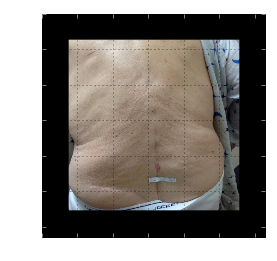

In [154]:
plt.imshow(image)

In [143]:
# image to patches
stride = 10

def im2patches(image, stride):
    """Tiles the image, striding, returning an N x 299 x 299 x 3 image array."""    
    stack = []
    M = image.shape[0]
    N = image.shape[1]
    i_count = 0
    for i in range(0, M-299, stride):
        i_count += 1
        j_count = 0        
        for j in range(0, N-299, stride):
            j_count += 1
            patch = image[i:i+299, j:j+299, :]
            patch = np.expand_dims(patch, 0)
            stack.append(patch)
    stack = np.vstack(stack)
    print i_count, j_count
    return stack
    
stack = im2patches(image, stride)

96 96


In [144]:
# Build Tensorflow Graph. Create Session. Feed 299x299 image patches through network, collecting softmax.

batch_size = 64
checkpoint_dir = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/detection/five-way/train_fast/'
classes = open('/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/detection/five-way/labels.txt').readlines()
num_classes = len(classes)
for c in classes:
    print c

with tf.Graph().as_default(), tf.Session() as sess:

    input_op = tf.placeholder(tf.float32, shape=(batch_size, 299, 299, 3))
    image_op = tf.sub(input_op, 0.5)
    image_op = tf.mul(image_op, 2.0)

    logits, _ = inception_model.inference(image_op, num_classes + 1)
    softmax = tf.nn.softmax(logits)

    variable_averages = tf.train.ExponentialMovingAverage(
        inception_model.MOVING_AVERAGE_DECAY)
    variables_to_restore = variable_averages.variables_to_restore()
    saver = tf.train.Saver(variables_to_restore)

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        if os.path.isabs(ckpt.model_checkpoint_path):
            # Restores from checkpoint with absolute path.
            saver.restore(sess, ckpt.model_checkpoint_path)
        else:
            # Restores from checkpoint with relative path.
            saver.restore(sess, os.path.join(checkpoint_dir,
                                             ckpt.model_checkpoint_path))

        # Assuming model_checkpoint_path looks something like:
        #   /my-favorite-path/imagenet_train/model.ckpt-0,
        # extract global_step from it.
        global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
        print('Succesfully loaded model from %s at step=%s.' %
            (ckpt.model_checkpoint_path, global_step))
    else:
        print('No checkpoint file found')
        
    # Extract softmax over the stack
    sm_stack = []
    for i in range(0, len(stack), batch_size):
        print '\rProcessing %d/%d' % (i, len(stack)),
        batch = stack[i:i+batch_size]
        if len(batch) < batch_size: # We're at the end
            n = len(batch)
            batch = stack[-batch_size:]
            sm = sess.run([softmax], feed_dict={input_op : batch})
            sm = sm[0][-n:]
        else:
            sm = sess.run([softmax], feed_dict={input_op : batch})
            sm = sm[0]
        sm_stack.append(sm)

epidermal-tumor-benign

epidermal-tumor-malignant

imagenet

pigmented-lesion-benign

pigmented-lesion-malignant

Succesfully loaded model from model.ckpt-4999 at step=4999.
Processing 9152/9216


In [145]:
# Convert softmax stack back to heatmap

h = [s for ss in sm_stack for s in ss]
M = image.shape[0]
N = image.shape[1]

# Reshape into MM x NN array
MM = (M-299) // stride + 1 # Size of heatmap image
NN = (N-299) // stride + 1
h = [h[i:i+NN] for i in range(0, MM * NN, NN)]
h = np.array(h)

# Merge into background, benign, and malignant heatmap
h0 = h[:,:, 0] + h[:,:,3] # unused background & imagenet
hb = h[:, :, 1] + h[:, :, 4] # benign
hm = h[:,:, 2] + h[:,:,5] # malignant probs
h = np.stack((h0,hb,hm), axis=2)

# Malignant prediction map
l1 = np.argmax(h, axis=2)
l2 = np.max(h, axis=2)

def ready(h):
    h = scipy.misc.imresize(h, (M-299, N-299), mode='F')
#     h = np.pad(h, pad_width=((149,149), (149,149)), mode='constant', constant_values=0)
    return h

# Malignant probability map
m = ready(h[:,:,2])
b = ready(h[:,:,1])

# Expand probability map to original size & pad edges
# m = m[m < 0.5]
# b = b[b < 0.5]

In [146]:
imagename

'/media/esteva/ExtraDrive1/ThrunResearch/figures/results_detection/00884783-1-1.jpg'

In [147]:
# Pass heatmap to yunzhu in his required format
import scipy.io

def ready_yunzhu(ll):
    tf_hw = 149
    ll = scipy.misc.imresize(ll, (M-299, N-299), mode="F")
    ll = np.pad(ll, pad_width=((tf_hw,tf_hw), (tf_hw,tf_hw)), mode='constant', constant_values=0)
    return ll

l1 = ready(l1)
l1 = np.round(l1)
l2 = ready(l2)
y = np.stack((l1,l2), axis=2)
print y.shape

file_name = '/tmp/aaai/' + os.path.basename(imagename) + '.mat'
mdict = {'heatmap' : y}

scipy.io.savemat(file_name, mdict, appendmat=True, format='5', 
                 long_field_names=False, do_compression=False, oned_as='row')

(959, 959, 2)


In [148]:
m[:10,:10]

array([[ 0.30824566,  0.30824566,  0.30824566,  0.30824566,  0.30824566,
         0.30964342,  0.31241018,  0.3151769 ,  0.31794363,  0.32071036],
       [ 0.30824566,  0.30824566,  0.30824566,  0.30824566,  0.30824566,
         0.30964342,  0.31241018,  0.3151769 ,  0.31794363,  0.32071036],
       [ 0.30824566,  0.30824566,  0.30824566,  0.30824566,  0.30824566,
         0.30964342,  0.31241018,  0.3151769 ,  0.31794363,  0.32071036],
       [ 0.30824566,  0.30824566,  0.30824566,  0.30824566,  0.30824566,
         0.30964342,  0.31241018,  0.3151769 ,  0.31794363,  0.32071036],
       [ 0.30824566,  0.30824566,  0.30824566,  0.30824566,  0.30824566,
         0.30964342,  0.31241018,  0.3151769 ,  0.31794363,  0.32071036],
       [ 0.30998677,  0.30998677,  0.30998677,  0.30998677,  0.30998677,
         0.31117356,  0.31352267,  0.31587178,  0.31822088,  0.32056999],
       [ 0.31343314,  0.31343314,  0.31343314,  0.31343314,  0.31343314,
         0.31420228,  0.31572476,  0.31724724

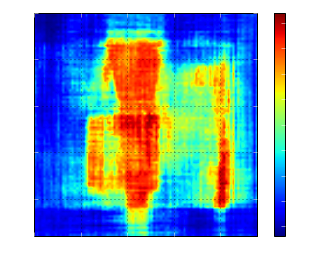

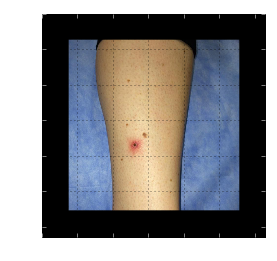

In [124]:
plt.imshow(m)
plt.colorbar()
plt.show()
plt.imshow(image)
plt.show()

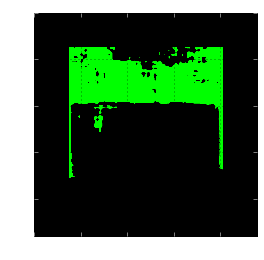

In [39]:
z = np.zeros((h.shape))
i = np.stack((z, h > 0.8, z), axis=2)
plt.imshow(i)

In [33]:
z.shape

(959, 959, 3)